## Define the path

In [ ]:
from pathlib import Path
import os
os.environ["DATA"] = os.path.expanduser("~/")
db_dir = os.environ["DATA"] + "PatImgXAI_data/db0.1.5_6x6/"
db = os.path.join(db_dir, "datasets")
db_json = os.path.join(db_dir, "db.json")

In [ ]:
HEX_TO_NAME = {
    "#7AB0CD": "blue",
    "#F4D67B": "yellow",
    "#F86C62": "red",
    "#87C09C": "green",
}

def get_position(symbol):
    """
    Get the position of the symbol
    :param symbol: loads the dictionary from db.json
    :return: the position of the symbol into chessboard labels (A1, B1, C1)
    """
    # passed the entire symbol dictionary from db.json (shape, color, pos)
    if isinstance(symbol, dict):
        column_idx, row_idx = symbol['pos']

    return f"{chr(ord('A') + column_idx)}{row_idx + 1}"


def get_positions(list_of_symbols):
    """
   This function convert coordinate [1,1] into chessboard labels (A1), and stored in explanation.json file
   :param list_of_symbols: takes in the meta data that contains symbols information from db.json
   :return: a list of positions: return a list of positions [(A1, B1, C1)]
    """
    positions_list = []

    for symbol in list_of_symbols:
        #turn the coordiante into labels [1,1] -> A1
        position_label = get_position(symbol)
        positions_list.append(position_label)

    return positions_list

def get_attributes(symbols, attribute):
    """
    :param symbol: loads the dictionary from db.json
    :param attribute: The attribute you want to collect from each symbol ('color', 'shape', 'pos')
    """
    if attribute == 'color':
        return [HEX_TO_NAME.get(s['color'], s['color']) for s in symbols]
    return [s[attribute] for s in symbols]



Rule function logic from the dataset generation

In [ ]:
def row_only_circles_rule(img_content):
    rows_with_shapes = {}
    for c in img_content:
      #pos is stored as (column,row)
        row = c['pos'][1]
        if row not in rows_with_shapes:
            rows_with_shapes[row] = []
        rows_with_shapes[row].append(c['shape'])

    for row in rows_with_shapes:
        shapes = rows_with_shapes[row]
        if all(shape == 'circle' for shape in shapes):
            return True

    return False

Extract the details of the shapes inside the image

In [ ]:
def logic_row_only_circles(img_content):
    """
    Builds a detailed explanation for the rule
    “at least one entire row contains only circles”.
    :param return: a dictionary describing whether
    the rule is met, which symbols and positions are relevant, and details
    for explanations (such as which rows qualify, and what shapes/colors are present).
    """
    all_symbols = img_content["content"]

    # If no row contains only circle return the following information
    if not row_only_circles_rule(all_symbols):
        return {
            "met": False,
            "relevant_symbols": [],
            "irrelevant_symbols": all_symbols,
            "relevant_positions": [],
            "irrelevant_positions": [get_position(s) for s in all_symbols],
            "relevant_shapes": [],
            "irrelevant_shapes": get_attributes(all_symbols, "shape"),
            "relevant_colors": [],
            "irrelevant_colors": get_attributes(all_symbols, "color"),
        }

    # Find every row that contains only circle
    rows_present = {s["pos"][1] for s in all_symbols}
    rows_only_circles = [
        row
        for row in rows_present
        if row_only_circles_rule([s for s in all_symbols if s["pos"][1] == row])
    ]

    # Separate relevant / irrelevant symbols
    relevant_symbols   = [s for s in all_symbols if s["pos"][1] in rows_only_circles]
    irrelevant_symbols = [s for s in all_symbols if s not in relevant_symbols]

    # Return the following explanation
    return {
        "met": True,
        "row_list": ", ".join(str(i + 1) for i in sorted(rows_only_circles)),  # 1-based rows
        "symbols_list": "; ".join(get_position(s) for s in relevant_symbols),
        "relevant_symbols": relevant_symbols,
        "irrelevant_symbols": irrelevant_symbols,
         "relevant_positions": [get_position(s) for s in relevant_symbols],
        "irrelevant_positions": [get_position(s) for s in irrelevant_symbols],
        "relevant_shapes": get_attributes(relevant_symbols,  "shape"),
        "irrelevant_shapes": get_attributes(irrelevant_symbols, "shape"),
        "relevant_colors": get_attributes(relevant_symbols,  "color"),
        "irrelevant_colors": get_attributes(irrelevant_symbols, "color"),

    }


In [ ]:
def red_in_row_2_rule(img_content):
    red_in_row_2 = False
    for c in img_content:
        if c['pos'][1] == 1 and c['color'] == "#F86C62":
            red_in_row_2 = True
            break

    if red_in_row_2:
        # Rule 1
        nb_triangles = 0
        nb_blue = 0
        for c in img_content:
            if c['shape'] == 'triangle':
                nb_triangles += 1
            if c['color'] == "#7AB0CD":
                nb_blue += 1
        return nb_triangles >= nb_blue
    else:
        # Rule 2
        nb_green = 0
        nb_squares = 0
        for c in img_content:
            if c['color'] == "#87C09C":
                nb_green += 1
            if c['shape'] == 'square':
                nb_squares += 1
        return nb_green >= nb_squares

In [ ]:
def logic_red_in_row_2(img_content):
    """
    Detailed explanation for the “red-in-row-2” rule.
    """
    # `img_content` is a dict coming from your JSON; we keep the shorter alias.
    all_symbols = img_content["content"]

    # Check the present of red symbols in row 2
    red_in_row_2 = any(
        s["pos"][1] == 1 and s["color"] == "#F86C62" for s in all_symbols
    )

    # Check if the rule sastified the condition
    rule_met = red_in_row_2_rule(all_symbols)

    # Gather the extra details that the explanation needs.
    # Apply Rule 1
    if red_in_row_2:
        triangles     = [s for s in all_symbols if s["shape"] == "triangle"]
        blue_symbols  = [s for s in all_symbols if s["color"] == "#7AB0CD"]

        relevant      = triangles + blue_symbols
        irrelevant    = [s for s in all_symbols if s not in relevant]

        return {
            "met": rule_met,
            "condition": "red_in_row_2",
            "nb_triangles": len(triangles),
            "nb_blue": len(blue_symbols),
            "op": ">=" if rule_met else "<",
            "triangles_list": "; ".join(get_position(s) for s in triangles) or "none",
            "blue_list": "; ".join(get_position(s) for s in blue_symbols) or "none",
            "relevant_symbols": relevant,
            "irrelevant_symbols": irrelevant,
            "relevant_positions":  [get_position(s) for s in relevant],
            "irrelevant_positions": [get_position(s) for s in irrelevant],
            "relevant_shapes":     get_attributes(relevant,   "shape"),
            "irrelevant_shapes":   get_attributes(irrelevant, "shape"),
            "relevant_colors":     get_attributes(relevant,   "color"),
            "irrelevant_colors":   get_attributes(irrelevant, "color"),
        }

    else:
        # Apply Rule 2
        green_symbols = [s for s in all_symbols if s["color"] == "#87C09C"]
        squares       = [s for s in all_symbols if s["shape"] == "square"]

        relevant      = green_symbols + squares
        irrelevant    = [s for s in all_symbols if s not in relevant]

        return {
            "met": rule_met,
            "condition": "no_red_in_row_2",
            "nb_green": len(green_symbols),
            "nb_squares": len(squares),
            "op": ">=" if rule_met else "<",
            "green_list": "; ".join(get_position(s) for s in green_symbols) or "none",
            "square_list": "; ".join(get_position(s) for s in squares) or "none",
            "relevant_symbols": relevant,
            "irrelevant_symbols": irrelevant,
            "relevant_positions":  [get_position(s) for s in relevant],
            "irrelevant_positions": [get_position(s) for s in irrelevant],
            "relevant_shapes":     get_attributes(relevant,   "shape"),
            "irrelevant_shapes":   get_attributes(irrelevant, "shape"),
            "relevant_colors":     get_attributes(relevant,   "color"),
            "irrelevant_colors":   get_attributes(irrelevant, "color"),
        }


## Define the rule explanation

In [ ]:
RULE_DEFINITIONS = {
    "row_only_circles": {
        "logic": logic_row_only_circles,
        "explanations": {
            "positive": "This image respects the 'at least one row with only circles' rule. The rule is met because row: {row_list} contain only circle symbols. The specific circles found are: {symbols_list}.",
            "negative": "This image does not respect the 'at least one row with only circles' rule, as no row was found to contain only circle symbols."
        }
    },
    "red_in_row_2": {
        "logic": logic_red_in_row_2,
        "explanations": {
            "positive": """
                Found red symbol in row 2 so we apply Rule 1 (triangles {nb_triangles} {op} blue {nb_blue}) the rule is respected.
                Triangles: [{triangles_list}]. Blue symbols: [{blue_list}].
            """,
            "negative": """
                Found red symbol in row 2 so we apply Rule 1 (triangles {nb_triangles} {op} blue {nb_blue}) the rule is not respected.
                Triangles: [{triangles_list}]. Blue symbols: [{blue_list}].
                """,
            "special": {
                "positive": """
                    No red symbol in row 2 so Apply Rule 2 (green {nb_green} {op} squares {nb_squares}) the rule is respected.
                    Green symbols: [{green_list}]. Squares: [{square_list}].
                """,
                "negative": """
                    No red symbol in row 2 so Apply Rule 2 (green {nb_green} {op} squares {nb_squares}) the rule is not respected.
                    Green symbols: [{green_list}]. Squares: [{square_list}].
                    """
            }
        }
    }
}

##Generate Explanation
Generates a detailed, structured explanation for an image and a specific rule.

In [ ]:
def generate_explanation(img_content, rule_name):
    """
    Generates a structured explanation with human-readable text
    :param img_content: the content of the image from db.json
    :param rule_name: the name of the rule to apply
    """
    # Get the requested rule and run the rule logic on the image
    rule = RULE_DEFINITIONS[rule_name]
    logic_result = rule["logic"](img_content)

    # Decide which explanation sentence to use
    human_explanation = ""
    template = ""

    # Check if the rule is the complex, conditional "red_in_row_2"
    if "condition" in logic_result:
        was_rule_met = logic_result["met"]

        if logic_result["condition"] == "red_in_row_2":
            # The condition was "red symbol was found in row 2".
            if was_rule_met:
                template = rule["explanations"]["positive"]
            else:
                template = rule["explanations"]["negative"]
        else:
            # The condition was "no red symbol in row 2".
            if was_rule_met:
                template = rule["explanations"]["special"]["positive"]
            else:
                template = rule["explanations"]["special"]["negative"]

        # Create the explanation sentence using data from **logic_result where it unpack the dictionary
        human_explanation = template.format(**logic_result)

    else:
        # This block runs for all the other, simpler rules.
        was_rule_met = logic_result["met"]

        if was_rule_met:
            template = rule["explanations"]["positive"]
        else:
            template = rule["explanations"]["negative"]

        human_explanation = template.format(**logic_result)

    final_explanation_object = {
        "human": human_explanation,
        "system": {
            "relevant_positions": logic_result.get(
                "relevant_positions",
                get_positions(logic_result["relevant_symbols"])
            ),
            "irrelevant_positions": logic_result.get(
                "irrelevant_positions",
                get_positions(logic_result["irrelevant_symbols"])
            ),
            "relevant_shapes":      logic_result.get("relevant_shapes",
                                                 get_attributes(logic_result["relevant_symbols"],  "shape")),
            "irrelevant_shapes":    logic_result.get("irrelevant_shapes",
                                                    get_attributes(logic_result["irrelevant_symbols"], "shape")),
            "relevant_colors":      logic_result.get("relevant_colors",
                                                    get_attributes(logic_result["relevant_symbols"],  "color")),
            "irrelevant_colors":    logic_result.get("irrelevant_colors",
                                                 get_attributes(logic_result["irrelevant_symbols"], "color")),
        },
    }


    return final_explanation_object

## Generate and store dataset explanation
It takes a dataset (CSV of images and labels), checks each image with a rule, creates a human+system explanation for each, and saves all the results to a new JSON file.

In [ ]:
import json
import pandas as pd
def generate_dataset_explanation(rule_name, dataset_filename, db, db_dict):
    """
    Generates and saves a dataset with structured explanations.
    :param rule_name: boolean function that defines whether the given image content is positive or negative.
    :param filenames: a list of dataset filenames (train,test,valid) to process.
    :param db: the path to the dataset directory.
    :param db_dict: a dictionary containing image content from db.json.
    """
    print(f"--- Processing {dataset_filename} for rule: {rule_name} ---")
    if rule_name not in RULE_DEFINITIONS:
        print(f"Error: No rule definition found for '{rule_name}'. Skipping.")
        return

    #load the dataset filename
    csv_file = os.path.join(db, dataset_filename)
    if not os.path.exists(csv_file):
        print(f"Warning: Input file not found at {csv_file}. Skipping.")
        return

    #the path to store the explanation file
    output_name = dataset_filename.replace(".csv", "_explanations.json")
    output_explanation_path = os.path.join(db, output_name)

    df = pd.read_csv(csv_file)
    results = []

    for _, row in df.iterrows():
        img_path = row["path"]
        img_id = Path(img_path).stem
        if img_id in db_dict:
            explanation_obj = generate_explanation(db_dict[img_id], rule_name)
            results.append({
                "path": img_path,
                "class": int(row["class"]),
                "explanation": explanation_obj
            })
        else:
            print(f"Warning: {img_id} not in db.json – skipping.")

    Path(output_explanation_path).parent.mkdir(parents=True, exist_ok=True)
    with open(output_explanation_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Successfully generated explanations. Saved to {output_explanation_path}\n")

In [ ]:
import json

with open(db_json, "r") as f:
    db_dict = json.load(f)

In [ ]:
def run_all_files_for_rule(rule_name, filenames, db, db_dict):
  """
  Processes multiple dataset files for a single rule.
  :param rule_name: boolean function that defines whether the given image content is positive or negative.
  :param filenames: a list of dataset filenames (train,test,valid) to process.
  :param db: the path to the dataset directory.
  :param db_dict: a dictionary containing image content from db.json.
  """
  for fname in filenames:
    generate_dataset_explanation(rule_name, fname, db, db_dict)

In [ ]:
run_all_files_for_rule("row_only_circles",
                     ["onlycircle_train.csv", "onlycircle_test.csv", "onlycircle_valid.csv"],
                     db, db_dict)

--- Processing onlycircle_train.csv for rule: row_only_circles ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/datasets/onlycircle_train_explanations.json

--- Processing onlycircle_test.csv for rule: row_only_circles ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/datasets/onlycircle_test_explanations.json

--- Processing onlycircle_valid.csv for rule: row_only_circles ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/datasets/onlycircle_valid_explanations.json



In [ ]:
run_all_files_for_rule("red_in_row_2",
                       ["red_in_row_2_train.csv", "red_in_row_2_test.csv", "red_in_row_2_valid.csv"],
                       db, db_dict)

--- Processing red_in_row_2_train.csv for rule: red_in_row_2 ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/datasets/red_in_row_2_train_explanations.json

--- Processing red_in_row_2_test.csv for rule: red_in_row_2 ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/datasets/red_in_row_2_test_explanations.json

--- Processing red_in_row_2_valid.csv for rule: red_in_row_2 ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db.vlm/datasets/red_in_row_2_valid_explanations.json



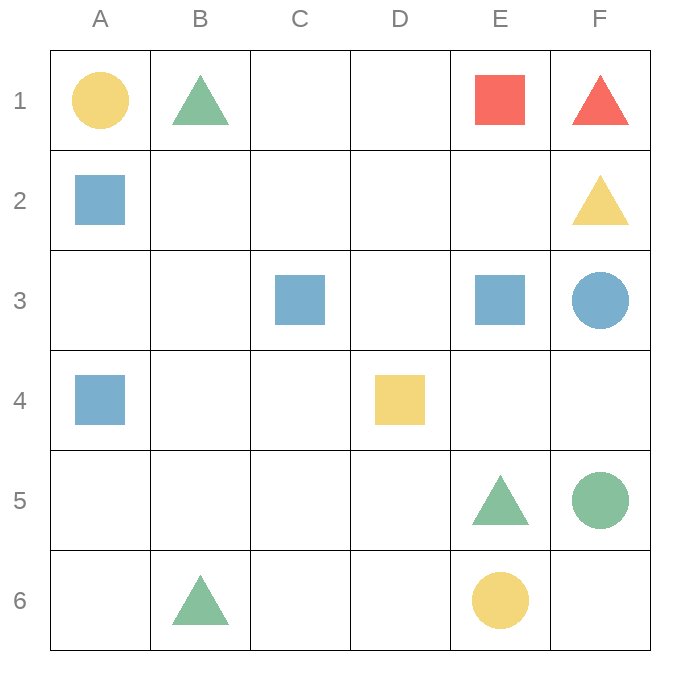

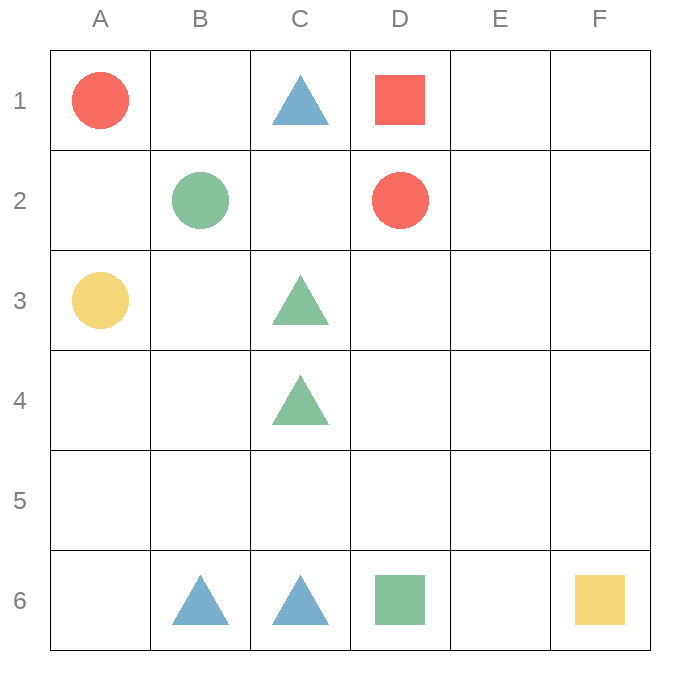

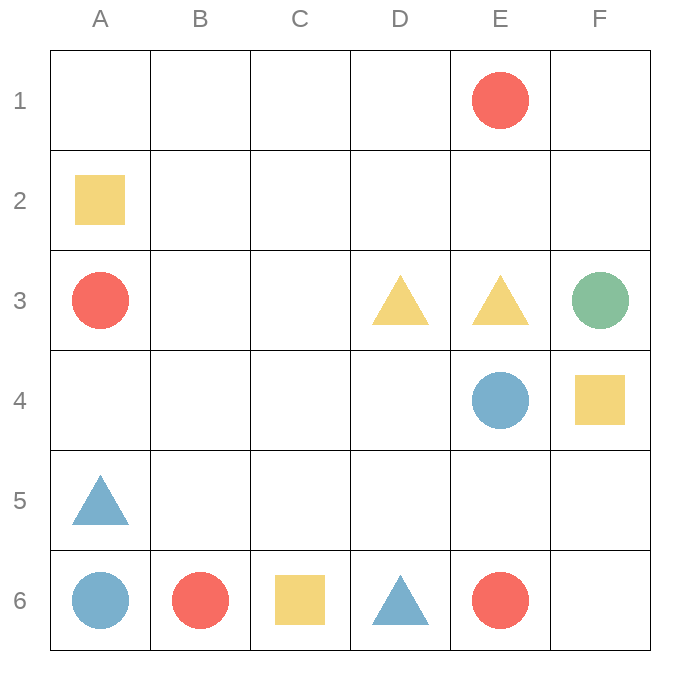

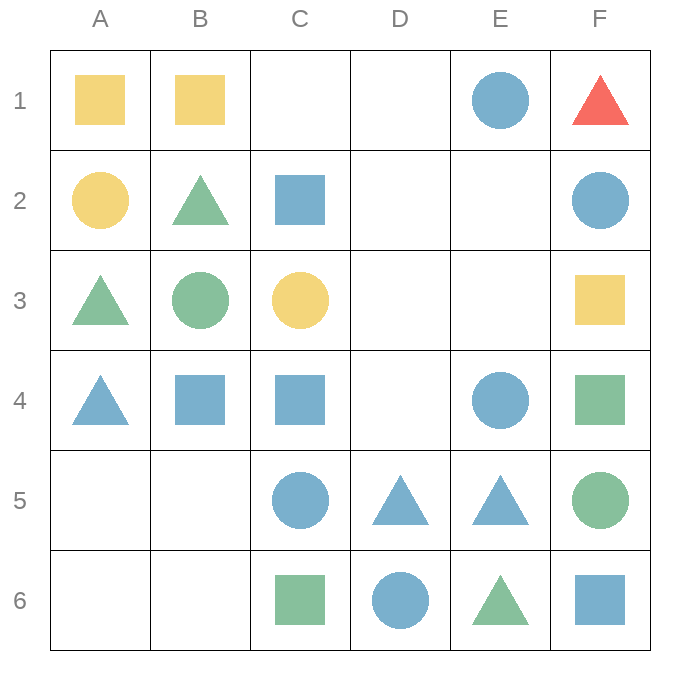

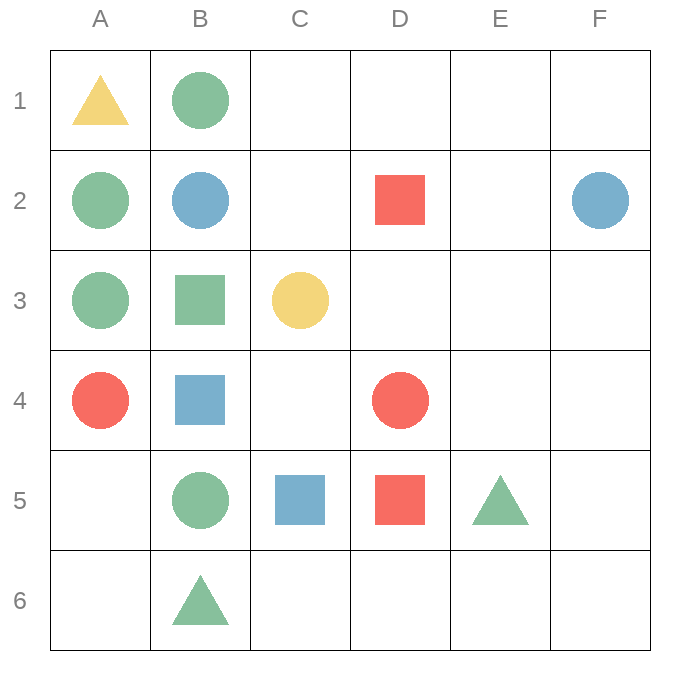

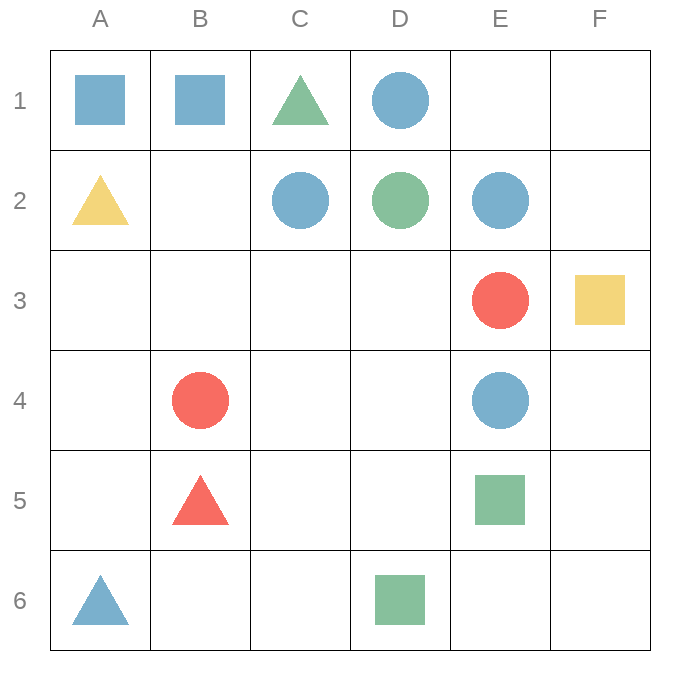

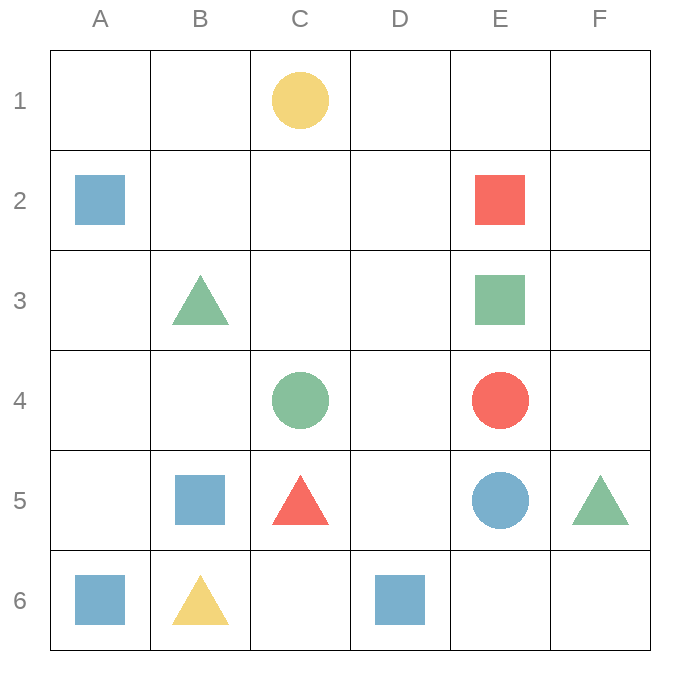

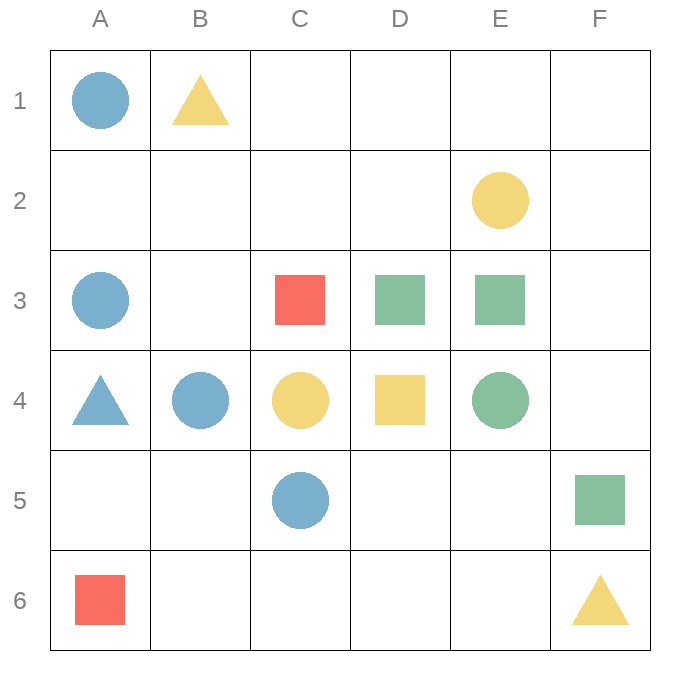

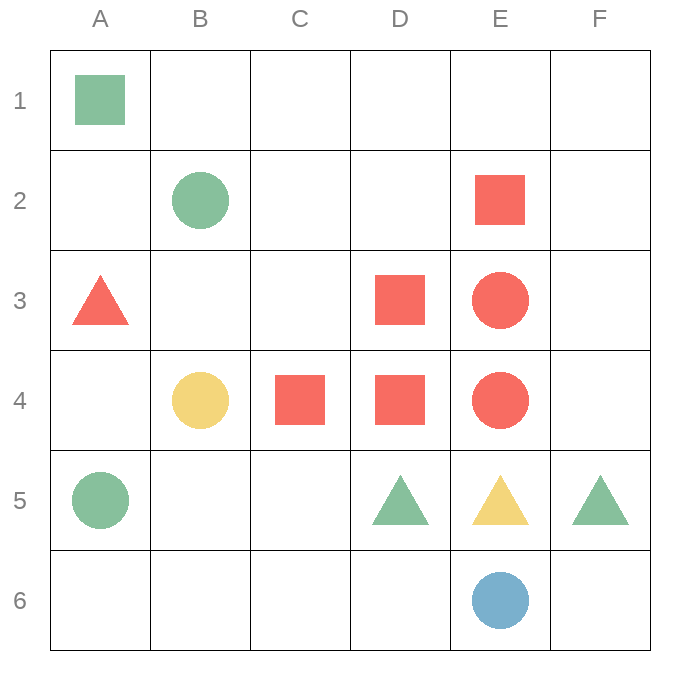

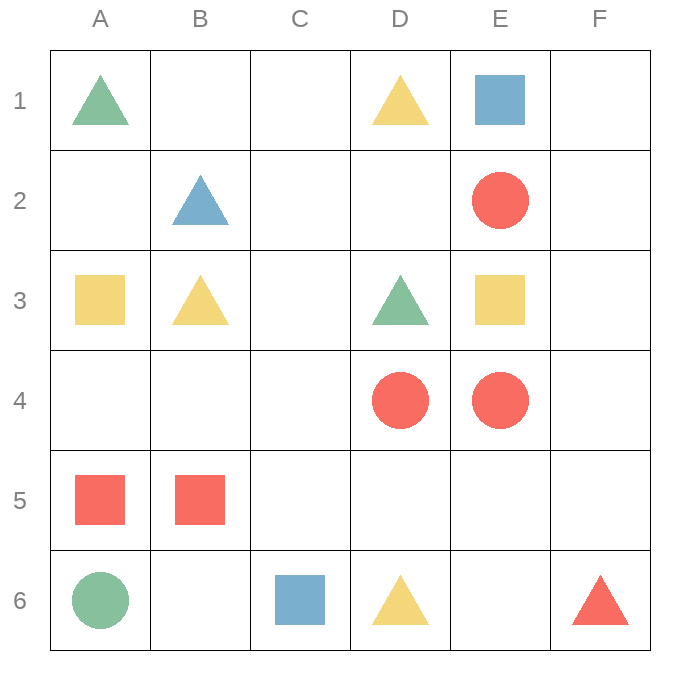

In [ ]:
from PIL import Image
from IPython.display import display, HTML
import os
import json # Import json here as well for completeness

image_dir = os.path.join(db_dir, "img")

# Specify the explanation file for the blue diagonal test dataset
explanation_filename = "onlycircle_test_explanations.json"
explanation_full_json_path = os.path.join(db_dir, explanation_filename)

# Check if the explanation file exists before attempting to open
if not os.path.exists(explanation_full_json_path):
    print(f"Error: Explanation file not found at {explanation_full_json_path}. Please ensure you have generated it.")
else:
    with open(explanation_full_json_path) as f:
        explanations = json.load(f)

    # ------------------------------------------------------------------
    # 3.  show some examples
    # ------------------------------------------------------------------
    MAX_SHOW = 10
    for item in explanations[:MAX_SHOW]:
        # Construct the full image path correctly
        img_path = os.path.join(image_dir, Path(item["path"]).name)
        caption  = f"<b>Class {item['class']}</b> — {item['explanation']['human']}"

        # display the image and its caption
        try:
            display(Image.open(img_path).convert("RGB"))
            display(HTML(caption))
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}. Skipping.")
        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")